In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

# Normalize the test set same as training set without augmentation
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])


trainset =  torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=64,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


truck  bird truck  deer


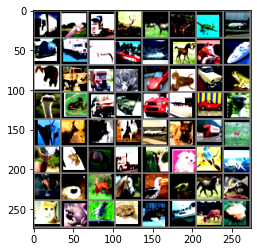

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [4]:
import torch.nn as nn
import torch.nn.functional as F
class Net(nn.Module):

    def __init__(self, dropout_rate):

        super(Net, self).__init__()

        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3, padding=1),  
            nn.ReLU(),
            nn.BatchNorm2d(10),
            nn.Dropout(dropout_rate),

            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=5, padding=1),  
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_rate)
        )

        self.transblock1 = nn.Sequential(
            #nn.MaxPool2d(2, 2),  
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=1,dilation=2)  
        )

        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1),  
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(0.2),

            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, padding=1), 
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(0.2)
        )

        self.transblock2 = nn.Sequential(
            #nn.MaxPool2d(2, 2),  
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1,dilation=2)  
        )

        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1), 
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(0.3),

            # Depthwise separable convolution
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, groups=32, padding=1),  
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=1),  
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(0.3)
        )

        self.transblock3 = nn.Sequential(
            #nn.MaxPool2d(2, 2),  
            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=1)  
        )

        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=5, padding=1,dilation=2 ),  
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_rate),

            
            #nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),  
            #nn.ReLU(),
            #nn.BatchNorm2d(64),
            #nn.Dropout(dropout_rate)
        )

        self.gap = nn.Sequential(
            nn.AdaptiveAvgPool2d(1)
        )  

        self.fc = nn.Sequential(
            nn.Linear(32, 10)
        )
    
    def forward(self, x):
        """ This function defines the network structure """

        x = self.convblock1(x)
        x = self.transblock1(x)
        x = self.convblock2(x)  + x
        x = self.transblock2(x)
        x = self.convblock3(x)  + x
        x = self.transblock3(x) 
        x = self.convblock4(x)  
        x = self.gap(x)
        x = x.view(-1, 32)
        x = self.fc(x)
        return x


net = Net(0.1)

In [5]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [6]:
!pip install torchsummary
from torchsummary import summary

model = net.to(device)  # Create model
summary(model, input_size=(3, 32, 32))  # Display model summary

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 32, 32]             280
              ReLU-2           [-1, 10, 32, 32]               0
       BatchNorm2d-3           [-1, 10, 32, 32]              20
           Dropout-4           [-1, 10, 32, 32]               0
            Conv2d-5           [-1, 16, 30, 30]           4,016
              ReLU-6           [-1, 16, 30, 30]               0
       BatchNorm2d-7           [-1, 16, 30, 30]              32
           Dropout-8           [-1, 16, 30, 30]               0
            Conv2d-9           [-1, 32, 30, 30]             544
           Conv2d-10           [-1, 32, 30, 30]           9,248
             ReLU-11           [-1, 32, 30, 30]               0
      BatchNorm2d-12           [-1, 32, 30, 30]              64
          Dropout-13           [-1, 32, 30, 30]               0
           Conv2d-14           [-1, 32,

In [7]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

In [8]:
from tqdm import tqdm
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    pbar = tqdm(train_loader)
    train_loss = 0
    correct = 0

    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        #loss = F.nll_loss(output, target)
        loss = criterion(output, target) 
        train_loss += loss.item()       
        loss.backward()
        optimizer.step()
        #scheduler.step()
        
        pbar.set_description(desc= f'loss={loss.item()} batch_id={batch_idx}')        
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        correct += pred.eq(target.view_as(pred)).sum().item()

    train_loss /= len(train_loader.dataset)
    print('\nTrain set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        train_loss, correct, len(train_loader.dataset),
        100. * correct / len(train_loader.dataset)))
    return train_loss, 100.*correct/len(train_loader.dataset)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return test_loss, 100.*correct/len(test_loader.dataset)

In [9]:
from torch.optim.lr_scheduler import StepLR,OneCycleLR

#model = Net().to(device)
lr = 0.01
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
#optimizer = optim.Adam(model.parameters(), lr=lr)

train_loss_list = []
test_loss_list = []
train_accuracy_list=[]
test_accuracy_list=[]

#optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
#scheduler = OneCycleLR(optimizer, max_lr=0.1,epochs=15,steps_per_epoch=len(trainloader))


for epoch in range(0, 100):
    print(f"Epoch {epoch}")
    # if(epoch % 4 == 0):
    #   lr = lr/10
    #   optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    if(epoch==25):
      optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.7)

    if(epoch==40):
      optimizer = optim.SGD(model.parameters(), lr=0.0001, momentum=0.9)
    
    train_loss,train_acc = train(model, device, trainloader, optimizer, epoch)
    #scheduler.step()
    test_loss,test_acc = test(model, device, testloader)

    train_loss_list.append(train_loss)
    test_loss_list.append(test_loss)

    train_accuracy_list.append(train_acc)
    test_accuracy_list.append(test_acc)

  0%|          | 0/782 [00:00<?, ?it/s]

Epoch 0


loss=1.1183648109436035 batch_id=781: 100%|██████████| 782/782 [00:49<00:00, 15.95it/s]


Train set: Average loss: 0.0244, Accuracy: 20872/50000 (41.74%)




  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: -3.1888, Accuracy: 5117/10000 (51.17%)

Epoch 1


loss=1.0685285329818726 batch_id=781: 100%|██████████| 782/782 [00:48<00:00, 16.07it/s]


Train set: Average loss: 0.0185, Accuracy: 28915/50000 (57.83%)




  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: -4.0717, Accuracy: 6126/10000 (61.26%)

Epoch 2


loss=0.8166853189468384 batch_id=781: 100%|██████████| 782/782 [00:48<00:00, 16.24it/s]


Train set: Average loss: 0.0163, Accuracy: 31508/50000 (63.02%)




  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: -5.2482, Accuracy: 6367/10000 (63.67%)

Epoch 3


loss=1.0189789533615112 batch_id=781: 100%|██████████| 782/782 [00:48<00:00, 16.26it/s]


Train set: Average loss: 0.0149, Accuracy: 33181/50000 (66.36%)




  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: -5.6797, Accuracy: 6965/10000 (69.65%)

Epoch 4


loss=0.5218309760093689 batch_id=781: 100%|██████████| 782/782 [00:48<00:00, 16.28it/s]


Train set: Average loss: 0.0137, Accuracy: 34393/50000 (68.79%)




  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: -5.9574, Accuracy: 7202/10000 (72.02%)

Epoch 5


loss=0.782128632068634 batch_id=781: 100%|██████████| 782/782 [00:48<00:00, 16.24it/s]


Train set: Average loss: 0.0129, Accuracy: 35531/50000 (71.06%)




  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: -6.3960, Accuracy: 7076/10000 (70.76%)

Epoch 6


loss=0.5801476240158081 batch_id=781: 100%|██████████| 782/782 [00:47<00:00, 16.30it/s]


Train set: Average loss: 0.0122, Accuracy: 36376/50000 (72.75%)




  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: -6.9331, Accuracy: 7442/10000 (74.42%)

Epoch 7


loss=1.2918745279312134 batch_id=781: 100%|██████████| 782/782 [00:47<00:00, 16.32it/s]


Train set: Average loss: 0.0116, Accuracy: 37127/50000 (74.25%)




  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: -6.7760, Accuracy: 7577/10000 (75.77%)

Epoch 8


loss=0.6646711230278015 batch_id=781: 100%|██████████| 782/782 [00:48<00:00, 16.27it/s]


Train set: Average loss: 0.0112, Accuracy: 37605/50000 (75.21%)




  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: -7.4157, Accuracy: 7535/10000 (75.35%)

Epoch 9


loss=0.5575310587882996 batch_id=781: 100%|██████████| 782/782 [00:48<00:00, 16.28it/s]


Train set: Average loss: 0.0108, Accuracy: 37956/50000 (75.91%)




  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: -7.5460, Accuracy: 7778/10000 (77.78%)

Epoch 10


loss=0.571142315864563 batch_id=781: 100%|██████████| 782/782 [00:48<00:00, 16.26it/s]


Train set: Average loss: 0.0104, Accuracy: 38394/50000 (76.79%)




  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: -7.5558, Accuracy: 7861/10000 (78.61%)

Epoch 11


loss=0.6512614488601685 batch_id=781: 100%|██████████| 782/782 [00:48<00:00, 16.19it/s]


Train set: Average loss: 0.0102, Accuracy: 38725/50000 (77.45%)




  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: -7.9984, Accuracy: 7956/10000 (79.56%)

Epoch 12


loss=0.3120328485965729 batch_id=781: 100%|██████████| 782/782 [00:48<00:00, 16.21it/s]


Train set: Average loss: 0.0099, Accuracy: 39125/50000 (78.25%)




  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: -8.4288, Accuracy: 8030/10000 (80.30%)

Epoch 13


loss=0.6660971641540527 batch_id=781: 100%|██████████| 782/782 [00:48<00:00, 16.26it/s]


Train set: Average loss: 0.0097, Accuracy: 39229/50000 (78.46%)




  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: -8.6215, Accuracy: 7966/10000 (79.66%)

Epoch 14


loss=0.5954949259757996 batch_id=781: 100%|██████████| 782/782 [00:48<00:00, 16.27it/s]


Train set: Average loss: 0.0095, Accuracy: 39576/50000 (79.15%)




  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: -8.2999, Accuracy: 7841/10000 (78.41%)

Epoch 15


loss=0.4864637851715088 batch_id=781: 100%|██████████| 782/782 [00:48<00:00, 16.21it/s]


Train set: Average loss: 0.0093, Accuracy: 39669/50000 (79.34%)




  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: -8.9183, Accuracy: 8097/10000 (80.97%)

Epoch 16


loss=0.5979516506195068 batch_id=781: 100%|██████████| 782/782 [00:48<00:00, 16.22it/s]



Train set: Average loss: 0.0091, Accuracy: 39889/50000 (79.78%)



  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: -8.2531, Accuracy: 8102/10000 (81.02%)

Epoch 17


loss=0.5149881839752197 batch_id=781: 100%|██████████| 782/782 [00:48<00:00, 16.25it/s]


Train set: Average loss: 0.0091, Accuracy: 39931/50000 (79.86%)




  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: -8.9044, Accuracy: 8104/10000 (81.04%)

Epoch 18


loss=1.1208446025848389 batch_id=781: 100%|██████████| 782/782 [00:48<00:00, 16.20it/s]


Train set: Average loss: 0.0088, Accuracy: 40271/50000 (80.54%)




  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: -8.7372, Accuracy: 8130/10000 (81.30%)

Epoch 19


loss=0.7814137935638428 batch_id=781: 100%|██████████| 782/782 [00:48<00:00, 16.24it/s]


Train set: Average loss: 0.0087, Accuracy: 40433/50000 (80.87%)




  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: -8.8215, Accuracy: 8076/10000 (80.76%)

Epoch 20


loss=0.40699002146720886 batch_id=781: 100%|██████████| 782/782 [00:48<00:00, 16.18it/s]


Train set: Average loss: 0.0086, Accuracy: 40458/50000 (80.92%)




  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: -9.3874, Accuracy: 8246/10000 (82.46%)

Epoch 21


loss=0.4355720281600952 batch_id=781: 100%|██████████| 782/782 [00:48<00:00, 16.25it/s]


Train set: Average loss: 0.0085, Accuracy: 40573/50000 (81.15%)




  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: -9.0130, Accuracy: 8223/10000 (82.23%)

Epoch 22


loss=0.6601172685623169 batch_id=781: 100%|██████████| 782/782 [00:48<00:00, 16.26it/s]


Train set: Average loss: 0.0084, Accuracy: 40783/50000 (81.57%)




  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: -9.1909, Accuracy: 8274/10000 (82.74%)

Epoch 23


loss=0.4948616027832031 batch_id=781: 100%|██████████| 782/782 [00:48<00:00, 16.21it/s]


Train set: Average loss: 0.0082, Accuracy: 40820/50000 (81.64%)




  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: -9.0421, Accuracy: 8289/10000 (82.89%)

Epoch 24


loss=0.5912094712257385 batch_id=781: 100%|██████████| 782/782 [00:48<00:00, 16.17it/s]


Train set: Average loss: 0.0081, Accuracy: 41009/50000 (82.02%)




  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: -9.1229, Accuracy: 8264/10000 (82.64%)

Epoch 25


loss=0.6459128260612488 batch_id=781: 100%|██████████| 782/782 [00:48<00:00, 16.16it/s]


Train set: Average loss: 0.0075, Accuracy: 41698/50000 (83.40%)




  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: -9.4409, Accuracy: 8431/10000 (84.31%)

Epoch 26


loss=0.43584898114204407 batch_id=781: 100%|██████████| 782/782 [00:48<00:00, 16.21it/s]


Train set: Average loss: 0.0071, Accuracy: 42085/50000 (84.17%)




  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: -9.6030, Accuracy: 8468/10000 (84.68%)

Epoch 27


loss=0.7610974907875061 batch_id=781: 100%|██████████| 782/782 [00:48<00:00, 16.19it/s]



Train set: Average loss: 0.0071, Accuracy: 42166/50000 (84.33%)



  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: -9.6997, Accuracy: 8482/10000 (84.82%)

Epoch 28


loss=0.7968977093696594 batch_id=781: 100%|██████████| 782/782 [00:48<00:00, 16.23it/s]


Train set: Average loss: 0.0071, Accuracy: 42147/50000 (84.29%)




  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: -9.8136, Accuracy: 8478/10000 (84.78%)

Epoch 29


loss=1.0055372714996338 batch_id=781: 100%|██████████| 782/782 [00:48<00:00, 16.19it/s]


Train set: Average loss: 0.0071, Accuracy: 42193/50000 (84.39%)




  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: -9.8675, Accuracy: 8510/10000 (85.10%)

Epoch 30


loss=0.6512649059295654 batch_id=781: 100%|██████████| 782/782 [00:48<00:00, 16.16it/s]


Train set: Average loss: 0.0069, Accuracy: 42309/50000 (84.62%)




  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: -10.0028, Accuracy: 8486/10000 (84.86%)

Epoch 31


loss=0.35162028670310974 batch_id=781: 100%|██████████| 782/782 [00:48<00:00, 16.21it/s]


Train set: Average loss: 0.0069, Accuracy: 42245/50000 (84.49%)




  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: -9.8729, Accuracy: 8516/10000 (85.16%)

Epoch 32


loss=0.35879361629486084 batch_id=781: 100%|██████████| 782/782 [00:48<00:00, 16.19it/s]


Train set: Average loss: 0.0069, Accuracy: 42380/50000 (84.76%)




  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: -9.8410, Accuracy: 8501/10000 (85.01%)

Epoch 33


loss=1.0297322273254395 batch_id=781: 100%|██████████| 782/782 [00:48<00:00, 16.11it/s]


Train set: Average loss: 0.0069, Accuracy: 42421/50000 (84.84%)




  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: -9.9632, Accuracy: 8515/10000 (85.15%)

Epoch 34


loss=0.611800491809845 batch_id=781: 100%|██████████| 782/782 [00:48<00:00, 16.13it/s]


Train set: Average loss: 0.0068, Accuracy: 42409/50000 (84.82%)




  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: -9.9092, Accuracy: 8502/10000 (85.02%)

Epoch 35


loss=0.5943586230278015 batch_id=781: 100%|██████████| 782/782 [00:48<00:00, 16.10it/s]


Train set: Average loss: 0.0069, Accuracy: 42544/50000 (85.09%)




  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: -10.0703, Accuracy: 8497/10000 (84.97%)

Epoch 36


loss=0.43160977959632874 batch_id=781: 100%|██████████| 782/782 [00:48<00:00, 16.07it/s]


Train set: Average loss: 0.0068, Accuracy: 42480/50000 (84.96%)




  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: -9.8801, Accuracy: 8517/10000 (85.17%)

Epoch 37


loss=0.46735841035842896 batch_id=781: 100%|██████████| 782/782 [00:48<00:00, 16.10it/s]


Train set: Average loss: 0.0068, Accuracy: 42476/50000 (84.95%)




  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: -10.0472, Accuracy: 8509/10000 (85.09%)

Epoch 38


loss=0.24011410772800446 batch_id=781: 100%|██████████| 782/782 [00:48<00:00, 16.10it/s]


Train set: Average loss: 0.0068, Accuracy: 42490/50000 (84.98%)




  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: -9.9885, Accuracy: 8524/10000 (85.24%)

Epoch 39


loss=0.40528687834739685 batch_id=781: 100%|██████████| 782/782 [00:48<00:00, 16.14it/s]


Train set: Average loss: 0.0068, Accuracy: 42432/50000 (84.86%)




  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: -10.1709, Accuracy: 8500/10000 (85.00%)

Epoch 40


loss=0.8164309859275818 batch_id=781: 100%|██████████| 782/782 [00:48<00:00, 16.14it/s]


Train set: Average loss: 0.0068, Accuracy: 42534/50000 (85.07%)




  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: -10.1570, Accuracy: 8502/10000 (85.02%)

Epoch 41


loss=0.3557363450527191 batch_id=781: 100%|██████████| 782/782 [00:48<00:00, 16.13it/s]


Train set: Average loss: 0.0068, Accuracy: 42523/50000 (85.05%)




  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: -10.2263, Accuracy: 8543/10000 (85.43%)

Epoch 42


loss=0.5931453108787537 batch_id=781: 100%|██████████| 782/782 [00:48<00:00, 16.15it/s]


Train set: Average loss: 0.0067, Accuracy: 42585/50000 (85.17%)




  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: -10.0855, Accuracy: 8508/10000 (85.08%)

Epoch 43


loss=0.5207757353782654 batch_id=781: 100%|██████████| 782/782 [00:48<00:00, 16.10it/s]


Train set: Average loss: 0.0068, Accuracy: 42537/50000 (85.07%)




  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: -10.1563, Accuracy: 8520/10000 (85.20%)

Epoch 44


loss=0.4185533821582794 batch_id=781: 100%|██████████| 782/782 [00:48<00:00, 16.06it/s]


Train set: Average loss: 0.0067, Accuracy: 42541/50000 (85.08%)




  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: -10.2119, Accuracy: 8515/10000 (85.15%)

Epoch 45


loss=1.1138805150985718 batch_id=781: 100%|██████████| 782/782 [00:48<00:00, 16.02it/s]


Train set: Average loss: 0.0067, Accuracy: 42633/50000 (85.27%)




  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: -10.1663, Accuracy: 8484/10000 (84.84%)

Epoch 46


loss=0.5931532979011536 batch_id=781: 100%|██████████| 782/782 [00:48<00:00, 16.15it/s]


Train set: Average loss: 0.0066, Accuracy: 42659/50000 (85.32%)




  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: -10.0926, Accuracy: 8522/10000 (85.22%)

Epoch 47


loss=0.4068106412887573 batch_id=781: 100%|██████████| 782/782 [00:48<00:00, 16.10it/s]


Train set: Average loss: 0.0068, Accuracy: 42504/50000 (85.01%)




  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: -10.1436, Accuracy: 8531/10000 (85.31%)

Epoch 48


loss=0.2346564531326294 batch_id=781: 100%|██████████| 782/782 [00:48<00:00, 16.09it/s]


Train set: Average loss: 0.0067, Accuracy: 42564/50000 (85.13%)




  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: -10.0769, Accuracy: 8500/10000 (85.00%)

Epoch 49


loss=0.8235336542129517 batch_id=781: 100%|██████████| 782/782 [00:48<00:00, 16.08it/s]


Train set: Average loss: 0.0067, Accuracy: 42550/50000 (85.10%)




  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: -10.0646, Accuracy: 8522/10000 (85.22%)

Epoch 50


loss=0.5399959087371826 batch_id=781: 100%|██████████| 782/782 [00:48<00:00, 16.06it/s]


Train set: Average loss: 0.0067, Accuracy: 42724/50000 (85.45%)




  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: -10.1241, Accuracy: 8530/10000 (85.30%)

Epoch 51


loss=0.6122975945472717 batch_id=781: 100%|██████████| 782/782 [00:48<00:00, 16.05it/s]


Train set: Average loss: 0.0067, Accuracy: 42514/50000 (85.03%)




  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: -10.0259, Accuracy: 8526/10000 (85.26%)

Epoch 52


loss=0.3544798493385315 batch_id=781: 100%|██████████| 782/782 [00:48<00:00, 16.08it/s]


Train set: Average loss: 0.0067, Accuracy: 42638/50000 (85.28%)




  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: -10.1193, Accuracy: 8507/10000 (85.07%)

Epoch 53


loss=0.5869988203048706 batch_id=781: 100%|██████████| 782/782 [00:48<00:00, 16.08it/s]


Train set: Average loss: 0.0067, Accuracy: 42597/50000 (85.19%)




  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: -10.1426, Accuracy: 8515/10000 (85.15%)

Epoch 54


loss=0.2545277774333954 batch_id=781: 100%|██████████| 782/782 [00:48<00:00, 16.01it/s]


Train set: Average loss: 0.0067, Accuracy: 42545/50000 (85.09%)




  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: -10.2448, Accuracy: 8524/10000 (85.24%)

Epoch 55


loss=0.4360674023628235 batch_id=781: 100%|██████████| 782/782 [00:48<00:00, 16.10it/s]


Train set: Average loss: 0.0067, Accuracy: 42571/50000 (85.14%)




  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: -10.1824, Accuracy: 8526/10000 (85.26%)

Epoch 56


loss=0.20143580436706543 batch_id=781: 100%|██████████| 782/782 [00:48<00:00, 16.01it/s]


Train set: Average loss: 0.0067, Accuracy: 42579/50000 (85.16%)




  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: -10.0951, Accuracy: 8507/10000 (85.07%)

Epoch 57


loss=0.33298006653785706 batch_id=781: 100%|██████████| 782/782 [00:48<00:00, 16.07it/s]


Train set: Average loss: 0.0067, Accuracy: 42546/50000 (85.09%)




  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: -10.3276, Accuracy: 8519/10000 (85.19%)

Epoch 58


loss=0.7070529460906982 batch_id=781: 100%|██████████| 782/782 [00:48<00:00, 16.06it/s]


Train set: Average loss: 0.0067, Accuracy: 42622/50000 (85.24%)




  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: -10.2116, Accuracy: 8503/10000 (85.03%)

Epoch 59


loss=0.30888059735298157 batch_id=781: 100%|██████████| 782/782 [00:48<00:00, 16.04it/s]


Train set: Average loss: 0.0067, Accuracy: 42663/50000 (85.33%)




  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: -10.1167, Accuracy: 8529/10000 (85.29%)

Epoch 60


loss=0.22239786386489868 batch_id=781: 100%|██████████| 782/782 [00:48<00:00, 16.00it/s]


Train set: Average loss: 0.0067, Accuracy: 42597/50000 (85.19%)




  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: -10.0798, Accuracy: 8505/10000 (85.05%)

Epoch 61


loss=0.7588987946510315 batch_id=781: 100%|██████████| 782/782 [00:48<00:00, 16.00it/s]



Train set: Average loss: 0.0067, Accuracy: 42649/50000 (85.30%)



  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: -10.3302, Accuracy: 8532/10000 (85.32%)

Epoch 62


loss=1.4942911863327026 batch_id=781: 100%|██████████| 782/782 [00:48<00:00, 16.00it/s]


Train set: Average loss: 0.0067, Accuracy: 42549/50000 (85.10%)




  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: -10.3614, Accuracy: 8519/10000 (85.19%)

Epoch 63


loss=0.10461904853582382 batch_id=781: 100%|██████████| 782/782 [00:48<00:00, 16.01it/s]


Train set: Average loss: 0.0066, Accuracy: 42582/50000 (85.16%)




  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: -10.0780, Accuracy: 8524/10000 (85.24%)

Epoch 64


loss=0.6429020762443542 batch_id=781: 100%|██████████| 782/782 [00:48<00:00, 16.01it/s]


Train set: Average loss: 0.0067, Accuracy: 42615/50000 (85.23%)




  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: -10.0931, Accuracy: 8517/10000 (85.17%)

Epoch 65


loss=1.0627461671829224 batch_id=781: 100%|██████████| 782/782 [00:48<00:00, 15.97it/s]


Train set: Average loss: 0.0066, Accuracy: 42709/50000 (85.42%)




  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: -10.1077, Accuracy: 8507/10000 (85.07%)

Epoch 66


loss=0.4063197672367096 batch_id=781: 100%|██████████| 782/782 [00:48<00:00, 15.98it/s]


Train set: Average loss: 0.0066, Accuracy: 42552/50000 (85.10%)




  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: -10.2610, Accuracy: 8511/10000 (85.11%)

Epoch 67


loss=0.3459703028202057 batch_id=781: 100%|██████████| 782/782 [00:48<00:00, 16.01it/s]


Train set: Average loss: 0.0067, Accuracy: 42650/50000 (85.30%)




  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: -10.1000, Accuracy: 8515/10000 (85.15%)

Epoch 68


loss=0.16878917813301086 batch_id=781: 100%|██████████| 782/782 [00:48<00:00, 16.05it/s]


Train set: Average loss: 0.0067, Accuracy: 42642/50000 (85.28%)




  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: -10.2257, Accuracy: 8518/10000 (85.18%)

Epoch 69


loss=0.4192841053009033 batch_id=781: 100%|██████████| 782/782 [00:48<00:00, 16.02it/s]


Train set: Average loss: 0.0066, Accuracy: 42784/50000 (85.57%)




  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: -10.2770, Accuracy: 8514/10000 (85.14%)

Epoch 70


loss=0.49423301219940186 batch_id=781: 100%|██████████| 782/782 [00:48<00:00, 15.98it/s]


Train set: Average loss: 0.0066, Accuracy: 42619/50000 (85.24%)




  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: -10.1552, Accuracy: 8517/10000 (85.17%)

Epoch 71


loss=0.3761056661605835 batch_id=781: 100%|██████████| 782/782 [00:48<00:00, 15.99it/s]


Train set: Average loss: 0.0067, Accuracy: 42545/50000 (85.09%)




  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: -10.1504, Accuracy: 8515/10000 (85.15%)

Epoch 72


loss=0.5646597146987915 batch_id=781: 100%|██████████| 782/782 [00:48<00:00, 15.99it/s]


Train set: Average loss: 0.0066, Accuracy: 42661/50000 (85.32%)




  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: -10.1897, Accuracy: 8514/10000 (85.14%)

Epoch 73


loss=0.1220952719449997 batch_id=781: 100%|██████████| 782/782 [00:49<00:00, 15.93it/s]


Train set: Average loss: 0.0067, Accuracy: 42644/50000 (85.29%)




  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: -10.1468, Accuracy: 8541/10000 (85.41%)

Epoch 74


loss=0.24099667370319366 batch_id=781: 100%|██████████| 782/782 [00:48<00:00, 15.98it/s]


Train set: Average loss: 0.0066, Accuracy: 42737/50000 (85.47%)




  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: -10.1833, Accuracy: 8528/10000 (85.28%)

Epoch 75


loss=0.46611231565475464 batch_id=781: 100%|██████████| 782/782 [00:48<00:00, 16.01it/s]


Train set: Average loss: 0.0065, Accuracy: 42816/50000 (85.63%)




  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: -10.2188, Accuracy: 8523/10000 (85.23%)

Epoch 76


loss=0.25996875762939453 batch_id=781: 100%|██████████| 782/782 [00:49<00:00, 15.93it/s]


Train set: Average loss: 0.0066, Accuracy: 42714/50000 (85.43%)




  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: -10.3251, Accuracy: 8523/10000 (85.23%)

Epoch 77


loss=0.7691543102264404 batch_id=781: 100%|██████████| 782/782 [00:48<00:00, 15.97it/s]


Train set: Average loss: 0.0066, Accuracy: 42741/50000 (85.48%)




  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: -10.1873, Accuracy: 8510/10000 (85.10%)

Epoch 78


loss=0.19093409180641174 batch_id=781: 100%|██████████| 782/782 [00:48<00:00, 15.96it/s]


Train set: Average loss: 0.0066, Accuracy: 42654/50000 (85.31%)




  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: -10.3691, Accuracy: 8515/10000 (85.15%)

Epoch 79


loss=0.38453418016433716 batch_id=781: 100%|██████████| 782/782 [00:49<00:00, 15.89it/s]


Train set: Average loss: 0.0067, Accuracy: 42600/50000 (85.20%)




  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: -10.2997, Accuracy: 8512/10000 (85.12%)

Epoch 80


loss=0.832351565361023 batch_id=781: 100%|██████████| 782/782 [00:49<00:00, 15.93it/s]


Train set: Average loss: 0.0066, Accuracy: 42694/50000 (85.39%)




  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: -10.2249, Accuracy: 8523/10000 (85.23%)

Epoch 81


loss=0.8082054853439331 batch_id=781: 100%|██████████| 782/782 [00:49<00:00, 15.91it/s]


Train set: Average loss: 0.0066, Accuracy: 42721/50000 (85.44%)




  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: -10.3460, Accuracy: 8542/10000 (85.42%)

Epoch 82


loss=1.054138422012329 batch_id=781: 100%|██████████| 782/782 [00:48<00:00, 15.98it/s]


Train set: Average loss: 0.0066, Accuracy: 42729/50000 (85.46%)




  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: -10.2262, Accuracy: 8520/10000 (85.20%)

Epoch 83


loss=0.3540292978286743 batch_id=781: 100%|██████████| 782/782 [00:49<00:00, 15.83it/s]


Train set: Average loss: 0.0066, Accuracy: 42631/50000 (85.26%)




  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: -10.3309, Accuracy: 8502/10000 (85.02%)

Epoch 84


loss=0.5594566464424133 batch_id=781: 100%|██████████| 782/782 [00:49<00:00, 15.90it/s]


Train set: Average loss: 0.0067, Accuracy: 42598/50000 (85.20%)




  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: -10.2158, Accuracy: 8539/10000 (85.39%)

Epoch 85


loss=0.7284270524978638 batch_id=781: 100%|██████████| 782/782 [00:49<00:00, 15.91it/s]


Train set: Average loss: 0.0066, Accuracy: 42715/50000 (85.43%)




  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: -10.1451, Accuracy: 8525/10000 (85.25%)

Epoch 86


loss=0.630430281162262 batch_id=781: 100%|██████████| 782/782 [00:49<00:00, 15.82it/s]


Train set: Average loss: 0.0066, Accuracy: 42728/50000 (85.46%)




  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: -10.2586, Accuracy: 8505/10000 (85.05%)

Epoch 87


loss=0.9565161466598511 batch_id=781: 100%|██████████| 782/782 [00:49<00:00, 15.86it/s]


Train set: Average loss: 0.0066, Accuracy: 42687/50000 (85.37%)




  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: -10.2562, Accuracy: 8520/10000 (85.20%)

Epoch 88


loss=0.45768702030181885 batch_id=781: 100%|██████████| 782/782 [00:49<00:00, 15.90it/s]


Train set: Average loss: 0.0066, Accuracy: 42671/50000 (85.34%)




  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: -10.4131, Accuracy: 8544/10000 (85.44%)

Epoch 89


loss=0.4364117681980133 batch_id=781: 100%|██████████| 782/782 [00:49<00:00, 15.87it/s]


Train set: Average loss: 0.0066, Accuracy: 42680/50000 (85.36%)




  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: -10.2614, Accuracy: 8525/10000 (85.25%)

Epoch 90


loss=0.2434311807155609 batch_id=781: 100%|██████████| 782/782 [00:49<00:00, 15.90it/s]


Train set: Average loss: 0.0066, Accuracy: 42724/50000 (85.45%)




  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: -10.2095, Accuracy: 8537/10000 (85.37%)

Epoch 91


loss=0.6038098335266113 batch_id=781: 100%|██████████| 782/782 [00:49<00:00, 15.91it/s]


Train set: Average loss: 0.0065, Accuracy: 42865/50000 (85.73%)




  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: -10.2706, Accuracy: 8533/10000 (85.33%)

Epoch 92


loss=0.5383520722389221 batch_id=781: 100%|██████████| 782/782 [00:49<00:00, 15.89it/s]


Train set: Average loss: 0.0066, Accuracy: 42691/50000 (85.38%)




  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: -10.4512, Accuracy: 8521/10000 (85.21%)

Epoch 93


loss=1.0822250843048096 batch_id=781: 100%|██████████| 782/782 [00:49<00:00, 15.87it/s]


Train set: Average loss: 0.0066, Accuracy: 42661/50000 (85.32%)




  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: -10.3360, Accuracy: 8529/10000 (85.29%)

Epoch 94


loss=0.3490771949291229 batch_id=781: 100%|██████████| 782/782 [00:49<00:00, 15.85it/s]



Train set: Average loss: 0.0066, Accuracy: 42667/50000 (85.33%)



  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: -10.2598, Accuracy: 8535/10000 (85.35%)

Epoch 95


loss=0.29628056287765503 batch_id=781: 100%|██████████| 782/782 [00:49<00:00, 15.90it/s]


Train set: Average loss: 0.0066, Accuracy: 42640/50000 (85.28%)




  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: -10.2841, Accuracy: 8539/10000 (85.39%)

Epoch 96


loss=0.3070535659790039 batch_id=781: 100%|██████████| 782/782 [00:49<00:00, 15.89it/s]


Train set: Average loss: 0.0065, Accuracy: 42737/50000 (85.47%)




  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: -10.3211, Accuracy: 8542/10000 (85.42%)

Epoch 97


loss=0.2534343898296356 batch_id=781: 100%|██████████| 782/782 [00:49<00:00, 15.84it/s]


Train set: Average loss: 0.0066, Accuracy: 42687/50000 (85.37%)




  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: -10.3485, Accuracy: 8533/10000 (85.33%)

Epoch 98


loss=0.29993391036987305 batch_id=781: 100%|██████████| 782/782 [00:49<00:00, 15.90it/s]


Train set: Average loss: 0.0066, Accuracy: 42744/50000 (85.49%)




  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: -10.3776, Accuracy: 8517/10000 (85.17%)

Epoch 99


loss=0.5600906610488892 batch_id=781: 100%|██████████| 782/782 [00:49<00:00, 15.89it/s]


Train set: Average loss: 0.0066, Accuracy: 42681/50000 (85.36%)




Test set: Average loss: -10.2585, Accuracy: 8532/10000 (85.32%)



In [10]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 85 %


In [11]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 92 %
Accuracy of   car : 94 %
Accuracy of  bird : 72 %
Accuracy of   cat : 72 %
Accuracy of  deer : 83 %
Accuracy of   dog : 79 %
Accuracy of  frog : 92 %
Accuracy of horse : 81 %
Accuracy of  ship : 98 %
Accuracy of truck : 93 %


Text(0.5, 1.0, 'Loss per epoch')

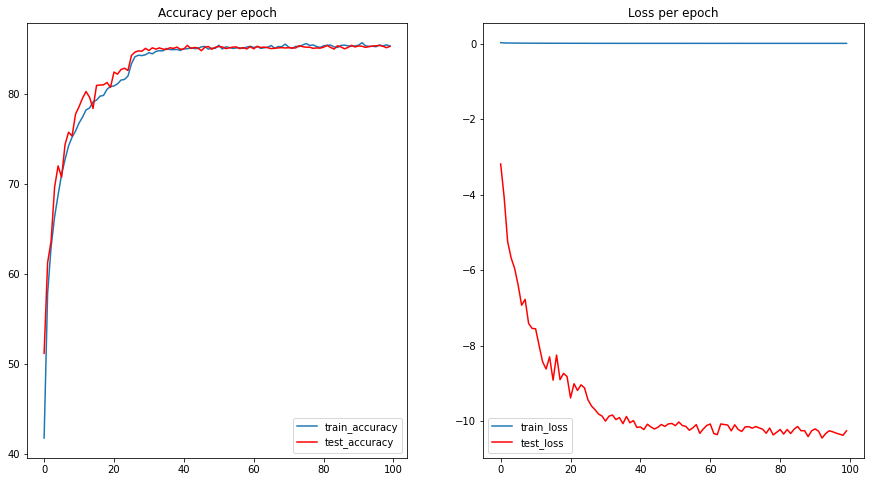

In [12]:
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [15, 8]

plt.subplot(1,2, 1)

plt.plot(np.array(train_accuracy_list))
plt.plot(np.array(test_accuracy_list), 'r')
plt.legend(["train_accuracy", "test_accuracy"])
plt.title("Accuracy per epoch")

plt.subplot(1,2,2)
plt.plot(train_loss_list)
plt.plot(test_loss_list, 'r')
plt.legend(["train_loss", "test_loss"])
plt.title("Loss per epoch")